## ECoG+STN-LFP dimentionality reduction analysis: demo 

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import mne
from mne.decoding import SPoC
mne.set_log_level(verbose='warning') #to avoid info at terminal
import pickle 
import sys
# from Utilities folder
sys.path.insert(1, './Utilities/icn_m1')
import os
sys.path.insert(1, './Utilities/')
from FilterBank import FilterBank
from ML_models import get_model

from collections import OrderedDict
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.linalg import norm
from pyglmnet import GLM

In [2]:
# define settings
# change them accordinly
settings = {}
settings['data_path'] = 'YOUR_ADDRESS'
settings['num_patients'] = ['000'] # for this example we only use one subject
# subfolders indicates the session in this dataset
settings['subfolders']=[['ses-right']]  # this subject only has one session

In [3]:
# define some experiments and model parameters
laterality = ["CON", "IPS"]

cv = KFold(n_splits=5, shuffle=False)
spoc = SPoC(n_components=1, log=True, reg='oas', transform_into ='average_power', rank='full')
USED_MODEL = 3 # 3 == GLM with alpha 0.5

### Load the data from both modalities.
This data was already pre-processed, following these steps:
1. Epochs of 100 ms were extracted.
2. Band-passed filtered epoched data at 8 frequency bands ([4, 8], [8, 12], [13, 20], [20, 35], [13, 35], [60, 80], [90, 200], [60, 200])
3. The target variable was downsampled accordinly to the 100 ms epoch lenght.

If you want to run this code with your own data, please be sure of arranging your data in a 4d array as follows:
(epochs, channels, samples, frequency bands)

In [4]:
# declare saving variable
Ypre_te = OrderedDict()
score_te = OrderedDict()
Coef = OrderedDict()
Label_te = OrderedDict()          
df = OrderedDict()        

In [5]:
s = 0 # when working with all subjects, this is a for
subfolders=settings["subfolders"][s]
ss = 0 # when working with all subjects, this is a for, since there are subjects which have more than one session.
X_ECOG = [] # to append data
X_STN =[] 
Y_con = []
Y_ips = []
list_of_files_ecog = os.listdir(settings['data_path']+'ECOG') # list of files in the current directory
list_of_files_stn = os.listdir(settings['data_path']+'STN') 

file_name_ = 'ECOG_epochs_sub_' + settings['num_patients'][s] + '_sess_'+subfolders[ss][4:]

file_ecog = [each_file for each_file in list_of_files_ecog if each_file.startswith(file_name_)]
file_name_='STN_epochs_sub_' + settings['num_patients'][s] + '_sess_'+subfolders[ss][4:]

# only load data from runs in which both modali
file_stn= [each_file for each_file in list_of_files_stn if each_file.startswith(file_name_)]
idx_file = [f for f in file_stn if list(set() & set(file_ecog))]
matching_stn = [f for f in file_stn if any(f[4:] in xs for xs in file_ecog)]
matching_ecog = [f for f in file_ecog if any(f[4:] in xs for xs in file_stn)]

if len(matching_ecog) != len(matching_stn):
    raise('Error loading data')

for e in range(len(matching_ecog)):
    with open(settings['data_path'] +'ECOG/' + matching_ecog[e], 'rb') as handle:
        sub_ = pickle.load(handle)    
        data = sub_['epochs']
        X_ECOG.append(data)
        label_ips = sub_['label_ips']
        label_con = sub_['label_con']
        Y_con.append(label_con)
        Y_ips.append(label_ips)
    with open(settings['data_path'] +'STN/' + matching_stn[e], 'rb') as handle:
        sub_ = pickle.load(handle)
        data = sub_['epochs']
        X_STN.append(data)           

X_ECOG = np.concatenate(X_ECOG, axis=0)
X_STN = np.concatenate(X_STN, axis=0)
Y_con = np.concatenate(Y_con, axis=0)
Y_ips = np.concatenate(Y_ips, axis=0)  

### Run the experiment!
(and be patient, it can take a time!)

In [6]:
for l, mov in enumerate(laterality):
    print("training %s" %mov)
    score_te[mov] = []
    Ypre_te[mov] = []
    Label_te[mov] = []
    Coef[mov] = []
    df[mov] = []

    if l==0:
        label=Y_con
    else:
        label=Y_ips

    features_ecog=FilterBank(estimator=spoc)
    features_stn=FilterBank(estimator=spoc)

    X_ECOG=X_ECOG.astype('float64')
    X_STN=X_STN.astype('float64')

    for train_index, test_index in cv.split(label):
        Ztr, Zte=label[train_index], label[test_index]
        Xtr_ecog, Xte_ecog=X_ECOG[train_index], X_ECOG[test_index]
        Xtr_stn, Xte_stn=X_STN[train_index], X_STN[test_index]
        Gtr_ecog_cspoc, Gtr_stn_cspoc = features_ecog.fit_transform(Xtr_ecog, Ztr), features_stn.fit_transform(Xtr_stn, Ztr)
        Gte_ecog_cspoc, Gte_stn_cspoc = features_ecog.transform(Xte_ecog), features_stn.transform(Xte_stn)

        dat_tr=np.hstack((Gtr_ecog_cspoc,Gtr_stn_cspoc))
        dat_te=np.hstack((Gte_ecog_cspoc,Gte_stn_cspoc))

        Label_te[mov].append(Zte)

        # dimenstionallity reduction is going to be done by manually adjusting the reg_lambda
        scaler = StandardScaler()
        scaler.fit(dat_tr)
        dat_tr = scaler.transform(dat_tr)
        dat_te = scaler.transform(dat_te)
        # ols solution, needed to estimate the lambda_min
        ols = LinearRegression()
        ols.fit(dat_tr, Ztr)
        beta_ols = ols.coef_
        lambda_min = norm((dat_tr * beta_ols).T * Ztr) / len(Ztr) #all values are non-zeros
        lambda_max = norm((dat_tr.T * Ztr), np.inf) / len(Ztr) # all values are zero
        rango = [lambda_min] * np.logspace(-2, 1,10)
        for rr, reg in enumerate(rango):

            clf=GLM(distr='poisson', alpha=0.5, score_metric='pseudo_R2', reg_lambda=reg)
            # fit the model
            clf.fit(dat_tr, Ztr)
            # predict
            Ypre_te[mov].append(clf.predict(dat_te))

            r2_te = r2_score(Zte, clf.predict(dat_te))
            if r2_te < 0: r2_te = 0
            score_te[mov].append(r2_te)
           
            Coef[mov].append(clf.beta_)
            df[mov].append(np.count_nonzero(clf.beta_)) #degree of freedom

        del Xtr_ecog, Xte_ecog, Xtr_stn, Xte_stn

training CON
training IPS


### Let's visualize the results

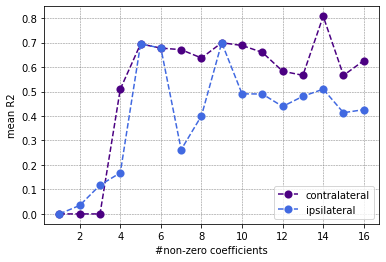

In [8]:
# plot R2 vs #non-zero coefficients
def duplicates(lst, item):
    return [i for i, x in enumerate(lst) if x == item]
score=np.zeros((16,))
fig, ax=plt.subplots()
name_laterality=["contralateral", "ipsilateral"]
colors=['indigo', 'royalblue']
for l, lat in enumerate(laterality):
    dof = df[lat]
    sc = score_te[lat]
    sc_sort = np.asarray([x for _,x in sorted(zip(dof,sc))])
    df_sort = [x for _,x in sorted(zip(dof,dof))]  
    index=np.argsort(dof)
    coef=Coef[lat]
    coef_sort=np.array(coef)[index.astype(int)]
    values_df=set(df_sort)
    sc_mean=[]
    for i, val in enumerate(values_df):
        ind_tomean=duplicates(df_sort, val)
        sc_mean=np.mean(sc_sort[np.asarray(ind_tomean)])
        score[val-1]=sc_mean
        
    ax.plot(np.arange(1,17,1),score, fillstyle='full', markeredgewidth=0.1,  marker='o', markersize=8, 
                        markerfacecolor=colors[l],
                        linestyle='--', color=colors[l],
                        label=name_laterality[l])
    
ax.grid(color='gray', linestyle='--', linewidth=0.5, axis='y')
ax.grid(color='gray', linestyle='--', linewidth=0.5, axis='x')
ax.set_ylabel("mean R2")
ax.set_xlabel("#non-zero coefficients")
ax.legend()

We can see how the sparsity in the solution impacts in the movement decoding performance. For this particular subject best decoding performance for contralateral movement is found when the number of non-zero coefficients in the solution is 14. If we compare these results to what is shown previously in the example "Example_ECoG+STN-LFP", it is easy to see that the ECoG+STN-LFP approach is superior than when either ECoG or STN recordings are used to make de decoding.